Libraries and Configuration

In [2]:
import os
import random
import math
from glob import glob
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

# ------------------------------
# Config / Hyperparameters
# ------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = "./data"  # directory with CSV files (one per clause category)
MAX_VOCAB = 30000
MAX_SEQ_LEN = 200
EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)


Device: cuda


Dataset Loading Utility

In [3]:

# ------------------------------
# Utilities: load CSVs and build dataset
# ------------------------------
def read_clause_files(data_dir: str) -> Dict[str, List[str]]:
    """
    Assume: each CSV in data_dir contains at least one column with clause text.
    We'll try to find a 'clause' or 'text' named column; otherwise use first text-like column.
    Return: dict mapping filename (category) -> list of clause texts
    """
    files = glob(os.path.join(data_dir, "*.csv"))
    categories = {}
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in {data_dir}. Please place dataset CSVs there.")
    for f in files:
        df = pd.read_csv(f)
        # try to locate text column
        text_col = None
        for candidate in ['clause', 'text', 'clause_text', 'Clause', 'Clause Text', 'clause_text']:
            if candidate in df.columns:
                text_col = candidate
                break
        if text_col is None:
            # fallback: find first object/string column
            for c in df.columns:
                if df[c].dtype == 'O':
                    text_col = c
                    break
        if text_col is None:
            print(f"Warning: no text column found in {f}, skipping.")
            continue
        texts = df[text_col].dropna().astype(str).tolist()
        cat_name = os.path.splitext(os.path.basename(f))[0]
        categories[cat_name] = texts
    return categories


Pair Generation (Positive and Negative Samples)

In [4]:

# ------------------------------
# Pair generation: positives (same category), negatives (different)
# ------------------------------
def generate_pairs(categories: Dict[str, List[str]], max_pairs_per_cat:int=2000, neg_pos_ratio:float=1.0):
    """
    Create dataset of pairs:
    - Positive pairs: random pairs within same category
    - Negative pairs: random pairs from different categories
    Balances approx according to neg_pos_ratio.
    """
    pairs = []
    cats = list(categories.keys())
    for cat in cats:
        texts = categories[cat]
        n = len(texts)
        if n < 2:
            continue
        # number of positive pairs for this category
        pairs_to_make = min(max_pairs_per_cat, n*(n-1)//2)
        # sample by random pairings
        idxs = list(range(n))
        made = 0
        attempts = 0
        while made < pairs_to_make and attempts < pairs_to_make * 5:
            a, b = random.sample(idxs, 2)
            pairs.append((texts[a], texts[b], 1))
            made += 1
            attempts += 1
    # negatives
    pos_count = sum(1 for _ in pairs)
    neg_needed = int(pos_count * neg_pos_ratio)
    # create negatives by sampling across categories
    all_texts = [(cat, t) for cat in categories for t in categories[cat]]
    cat_to_indices = {cat: list(range(len(categories[cat]))) for cat in categories}
    made_neg = 0
    attempts = 0
    while made_neg < neg_needed and attempts < neg_needed * 10:
        c1, c2 = random.sample(cats, 2)
        t1 = random.choice(categories[c1])
        t2 = random.choice(categories[c2])
        pairs.append((t1, t2, 0))
        made_neg += 1
        attempts += 1
    random.shuffle(pairs)
    return pairs


Tokenization and Vocabulary Building

In [5]:

# ------------------------------
# Simple tokenizer & vocab
# ------------------------------
def simple_tokenize(s: str) -> List[str]:
    # lower, basic punctuation split
    s = s.strip().lower()
    # replace common punctuation with spaces
    for ch in ['\n', '\t', ',', ';', '(', ')', ':', '"', "'"]:
        s = s.replace(ch, ' ')
    tokens = s.split()
    return tokens

class Vocab:
    def __init__(self, max_size=30000, min_freq=1, unk_token="<UNK>", pad_token="<PAD>"):
        self.max_size = max_size
        self.min_freq = min_freq
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.token2idx = {}
        self.idx2token = []
        self.freqs = Counter()
        # will be built with build_from_texts
    def build_from_texts(self, texts: List[str]):
        for t in texts:
            self.freqs.update(simple_tokenize(t))
        # keep tokens above min_freq and up to max_size-2 (for PAD & UNK)
        tokens = [tok for tok, c in self.freqs.most_common(self.max_size)]
        # ensure PAD=0, UNK=1
        self.idx2token = [self.pad_token, self.unk_token] + tokens
        self.token2idx = {t:i for i,t in enumerate(self.idx2token)}
    def encode(self, text: str, max_len: int) -> List[int]:
        toks = simple_tokenize(text)
        ids = []
        for tok in toks[:max_len]:
            ids.append(self.token2idx.get(tok, self.token2idx.get(self.unk_token)))
        # pad
        if len(ids) < max_len:
            ids += [self.token2idx[self.pad_token]] * (max_len - len(ids))
        return ids


Custom Dataset Class

In [6]:

# ------------------------------
# Dataset class
# ------------------------------
class ClausePairDataset(Dataset):
    def __init__(self, pairs: List[Tuple[str,str,int]], vocab: Vocab, max_len: int):
        self.pairs = pairs
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        s1, s2, label = self.pairs[idx]
        x1 = torch.tensor(self.vocab.encode(s1, self.max_len), dtype=torch.long)
        x2 = torch.tensor(self.vocab.encode(s2, self.max_len), dtype=torch.long)
        return x1, x2, torch.tensor(label, dtype=torch.float32)


Model Architectures (Siamese BiLSTM & Self-Attention Encoder)

In [7]:

# ------------------------------
# Models
# ------------------------------
class SiameseBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, n_layers=1, dropout=0.2, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True, 
                              bidirectional=bidirectional, dropout=dropout if n_layers>1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        rep_dim = hidden_dim * (2 if bidirectional else 1)
        # projection for embeddings
        self.proj = nn.Sequential(
            nn.Linear(rep_dim, rep_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # final classifier from similarity features
        self.classifier = nn.Sequential(
            nn.Linear(3*rep_dim, rep_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(rep_dim, 1)
        )
    def encode(self, x):
        # x: (B, L)
        emb = self.embedding(x)  # B L E
        out, (h_n, c_n) = self.bilstm(emb)  # out: B L (H*2)
        # use max-pool over time + last hidden concat (common trick)
        # out maxpool:
        out_max, _ = torch.max(out, dim=1)  # B, rep
        # optional projection:
        rep = self.proj(out_max)
        return rep
    def forward(self, x1, x2):
        r1 = self.encode(x1)
        r2 = self.encode(x2)
        diff = torch.abs(r1 - r2)
        mult = r1 * r2
        feat = torch.cat([r1, diff, mult], dim=1)
        logits = self.classifier(feat).squeeze(-1)
        return logits, torch.sigmoid(logits), r1, r2

class SelfAttentionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, n_heads=4, ff_hidden=256, n_layers=1, dropout=0.2, max_len=200):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_hidden, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.AdaptiveMaxPool1d(1)
        # classifier: concat encoded vectors then FC
        feat_dim = embed_dim * 3  # r1, diff, mult
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, ff_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden, 1)
        )
    def encode(self, x):
        # x: B L
        emb = self.embedding(x)  # B L E
        # create src_key_padding_mask
        mask = (x == 0)  # PAD index = 0
        enc = self.transformer(emb, src_key_padding_mask=mask)  # B L E
        # adaptive max pool across length to get B x E
        enc_t = enc.transpose(1,2)  # B E L
        pooled = F.adaptive_max_pool1d(enc_t, 1).squeeze(-1)  # B E
        return pooled
    def forward(self, x1, x2):
        r1 = self.encode(x1)
        r2 = self.encode(x2)
        diff = torch.abs(r1 - r2)
        mult = r1 * r2
        feat = torch.cat([r1, diff, mult], dim=1)
        logits = self.classifier(feat).squeeze(-1)
        return logits, torch.sigmoid(logits), r1, r2


Training and Evaluation Utilities

In [8]:

# ------------------------------
# Training & Evaluation utilities
# ------------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x1, x2, y in tqdm(dataloader, desc="train batches", leave=False):
        x1 = x1.to(device); x2 = x2.to(device); y = y.to(device)
        optimizer.zero_grad()
        logits, probs, *_ = model(x1, x2)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x1.size(0)
    return total_loss / len(dataloader.dataset)

def eval_model(model, dataloader, device):
    model.eval()
    ys = []
    probs_all = []
    preds = []
    with torch.no_grad():
        for x1, x2, y in dataloader:
            x1 = x1.to(device); x2 = x2.to(device)
            logits, probs, *_ = model(x1, x2)
            probs = probs.detach().cpu().numpy()
            logits = logits.detach().cpu().numpy()
            y_np = y.numpy()
            pred = (probs >= 0.5).astype(int)
            ys.extend(y_np.tolist())
            probs_all.extend(probs.tolist())
            preds.extend(pred.tolist())
    # compute metrics
    acc = accuracy_score(ys, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(ys, preds, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(ys, probs_all)
    except:
        roc = float('nan')
    try:
        pr = average_precision_score(ys, probs_all)
    except:
        pr = float('nan')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc, "pr_auc": pr, "y": ys, "probs": probs_all, "preds": preds}


Dataset Preparation and DataLoader Setup

In [9]:

# ------------------------------
# Main: prepare data, vocab, dataloaders
# ------------------------------
# 1) Read data files
categories = read_clause_files(DATA_DIR)
print(f"Loaded {len(categories)} categories.")
total_clauses = sum(len(v) for v in categories.values())
print("Total clauses:", total_clauses)

# 2) Generate pairs
pairs = generate_pairs(categories, max_pairs_per_cat=800, neg_pos_ratio=1.0)
print("Total pairs generated:", len(pairs))
# quick sanity sample:
print("Sample pair (label):", pairs[0][0][:80], "...", pairs[0][1][:80], pairs[0][2])

# 3) Build vocab
all_texts = []
for cat in categories:
    all_texts.extend(categories[cat])
vocab = Vocab(max_size=MAX_VOCAB)
vocab.build_from_texts(all_texts)
vocab_size = len(vocab.idx2token)
print("Vocab size:", vocab_size)

# 4) Train/val/test split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=SEED, stratify=[p[2] for p in pairs])
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.15, random_state=SEED, stratify=[p[2] for p in train_pairs])

train_ds = ClausePairDataset(train_pairs, vocab, MAX_SEQ_LEN)
val_ds = ClausePairDataset(val_pairs, vocab, MAX_SEQ_LEN)
test_ds = ClausePairDataset(test_pairs, vocab, MAX_SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))


Loaded 395 categories.
Total clauses: 150881
Total pairs generated: 630610
Sample pair (label): Investment Company Act. None of the Borrowers is required to be registered as an ... Investment Company Act. The Borrower is not (i) an “investment company” or a com 1
Vocab size: 30002
Sizes -> train: 455615 val: 80403 test: 94592


Class Distribution Analysis


=== Training Set Class Distribution ===
Similar (1): 227808 samples (50.00%)
Dissimilar (0): 227807 samples (50.00%)
Total samples: 455615

=== Validation Set Class Distribution ===
Similar (1): 40201 samples (50.00%)
Dissimilar (0): 40202 samples (50.00%)
Total samples: 80403

=== Test Set Class Distribution ===
Dissimilar (0): 47296 samples (50.00%)
Similar (1): 47296 samples (50.00%)
Total samples: 94592


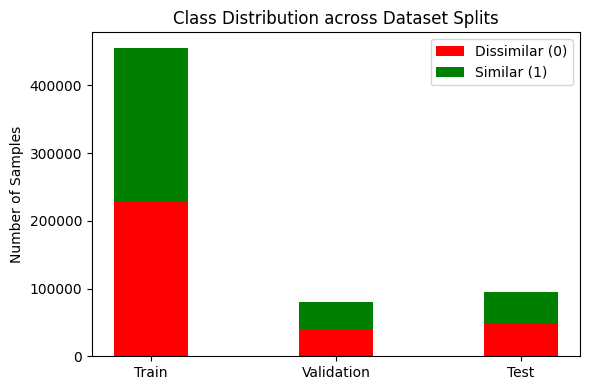

In [10]:
# ============================================================
# Class Distribution Analysis — Check for Imbalance
# ============================================================

# Extract labels from training, validation, and test sets
train_labels = [label for (_, _, label) in train_pairs]
val_labels = [label for (_, _, label) in val_pairs]
test_labels = [label for (_, _, label) in test_pairs]

# Count positive and negative examples in each split
from collections import Counter

def show_class_distribution(labels, split_name):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n=== {split_name} Set Class Distribution ===")
    for k, v in counter.items():
        pct = (v / total) * 100
        label_name = "Similar (1)" if k == 1 else "Dissimilar (0)"
        print(f"{label_name}: {v} samples ({pct:.2f}%)")
    print(f"Total samples: {total}")

# Display for each dataset split
show_class_distribution(train_labels, "Training")
show_class_distribution(val_labels, "Validation")
show_class_distribution(test_labels, "Test")

# Optional: visualize the class balance as a bar chart
import matplotlib.pyplot as plt

splits = ["Train", "Validation", "Test"]
pos_counts = [Counter(train_labels)[1], Counter(val_labels)[1], Counter(test_labels)[1]]
neg_counts = [Counter(train_labels)[0], Counter(val_labels)[0], Counter(test_labels)[0]]

x = range(len(splits))
plt.figure(figsize=(6,4))
plt.bar(x, neg_counts, width=0.4, label="Dissimilar (0)", color='red')
plt.bar(x, pos_counts, width=0.4, bottom=neg_counts, label="Similar (1)", color='green')
plt.xticks(x, splits)
plt.ylabel("Number of Samples")
plt.title("Class Distribution across Dataset Splits")
plt.legend()
plt.tight_layout()
plt.show()


Training Function for Both Models

In [10]:

# ------------------------------
# Train both models (Siamese + Attention)
# ------------------------------
def fit_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE, device=DEVICE, model_name="model"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # We compute BCEWithLogitsLoss on logits; models' forward returns logits
    criterion = lambda logits, y: F.binary_cross_entropy_with_logits(logits, y)
    best_val_f1 = -1
    best_state = None
    history = {"train_loss": [], "val_f1": [], "val_acc": []}
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs} ----------------")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        print("Train loss:", train_loss)
        # eval
        metrics = eval_model(model, val_loader, device)
        print(f"Val acc: {metrics['accuracy']:.4f}, f1: {metrics['f1']:.4f}, prec: {metrics['precision']:.4f}, rec: {metrics['recall']:.4f}, roc_auc: {metrics['roc_auc']:.4f}")
        history["train_loss"].append(train_loss)
        history["val_f1"].append(metrics['f1'])
        history["val_acc"].append(metrics['accuracy'])
        if metrics['f1'] > best_val_f1:
            best_val_f1 = metrics['f1']
            best_state = {
                "model_state": model.state_dict(),
                "epoch": epoch,
                "val_metrics": metrics
            }
            # save checkpoint
            torch.save(best_state, f"{model_name}_best.pt")
            print("Saved best model.")
    return best_state, history


Train Siamese BiLSTM Model

In [13]:

# Train SiameseBiLSTM
print("\n=== Training Siamese BiLSTM ===")
siamese = SiameseBiLSTM(vocab_size=vocab_size, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM)
best_siamese, hist_siamese = fit_model(siamese, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE, device=DEVICE, model_name="siamese_bilstm")



=== Training Siamese BiLSTM ===

Epoch 1/10 ----------------


Train loss: 0.05032013696913546
Val acc: 0.9971, f1: 0.9971, prec: 0.9947, rec: 0.9996, roc_auc: 0.9999
Saved best model.

Epoch 2/10 ----------------


Train loss: 0.0055029958713434845
Val acc: 0.9984, f1: 0.9984, prec: 0.9970, rec: 0.9999, roc_auc: 1.0000
Saved best model.

Epoch 3/10 ----------------


Train loss: 0.0032218440803768195
Val acc: 0.9975, f1: 0.9975, prec: 0.9952, rec: 0.9999, roc_auc: 1.0000

Epoch 4/10 ----------------


Train loss: 0.0025856040246518266
Val acc: 0.9993, f1: 0.9993, prec: 0.9986, rec: 1.0000, roc_auc: 1.0000
Saved best model.

Epoch 5/10 ----------------


Train loss: 0.0021389683179993445
Val acc: 0.9989, f1: 0.9989, prec: 0.9977, rec: 1.0000, roc_auc: 1.0000

Epoch 6/10 ----------------


Train loss: 0.0019926718481327274
Val acc: 0.9996, f1: 0.9996, prec: 0.9991, rec: 1.0000, roc_auc: 1.0000
Saved best model.

Epoch 7/10 ----------------


Train loss: 0.0020070477873190885
Val acc: 0.9992, f1: 0.9992, prec: 0.9984, rec: 1.0000, roc_auc: 1.0000

Epoch 8/10 ----------------


Train loss: 0.0019301533300130195
Val acc: 0.9997, f1: 0.9997, prec: 0.9994, rec: 1.0000, roc_auc: 1.0000
Saved best model.

Epoch 9/10 ----------------


Train loss: 0.0016619329655586364
Val acc: 0.9996, f1: 0.9996, prec: 0.9993, rec: 0.9999, roc_auc: 0.9999

Epoch 10/10 ----------------


Train loss: 0.0015909800381535
Val acc: 0.9992, f1: 0.9992, prec: 0.9985, rec: 1.0000, roc_auc: 0.9999


Train Self-Attention Encoder Model

In [11]:

# Train SelfAttentionEncoder
print("\n=== Training Self-Attention Encoder ===")
attn_model = SelfAttentionEncoder(vocab_size=vocab_size, embed_dim=EMBED_DIM, n_heads=4, ff_hidden=HIDDEN_DIM*2, n_layers=1, dropout=0.2, max_len=MAX_SEQ_LEN)
best_attn, hist_attn = fit_model(attn_model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE, device=DEVICE, model_name="attn_encoder")



=== Training Self-Attention Encoder ===

Epoch 1/10 ----------------


C:\Users\Ayaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Train loss: 0.19682049084463646
Val acc: 0.9289, f1: 0.9238, prec: 0.9953, rec: 0.8620, roc_auc: 0.9928
Saved best model.

Epoch 2/10 ----------------


Train loss: 0.06403748769277816
Val acc: 0.9383, f1: 0.9346, prec: 0.9958, rec: 0.8804, roc_auc: 0.9961
Saved best model.

Epoch 3/10 ----------------


Train loss: 0.045569509759460045
Val acc: 0.9366, f1: 0.9325, prec: 0.9958, rec: 0.8768, roc_auc: 0.9960

Epoch 4/10 ----------------


Train loss: 0.03979542985842721
Val acc: 0.9313, f1: 0.9265, prec: 0.9955, rec: 0.8664, roc_auc: 0.9953

Epoch 5/10 ----------------


Train loss: 0.03701065863957366
Val acc: 0.9207, f1: 0.9142, prec: 0.9960, rec: 0.8447, roc_auc: 0.9954

Epoch 6/10 ----------------


Train loss: 0.03656851618153948
Val acc: 0.9009, f1: 0.8904, prec: 0.9956, rec: 0.8053, roc_auc: 0.9928

Epoch 7/10 ----------------


Train loss: 0.03424889104101263
Val acc: 0.8752, f1: 0.8579, prec: 0.9956, rec: 0.7537, roc_auc: 0.9920

Epoch 8/10 ----------------


Train loss: 0.0332352993527915
Val acc: 0.8718, f1: 0.8534, prec: 0.9958, rec: 0.7467, roc_auc: 0.9913

Epoch 9/10 ----------------


Train loss: 0.03306576369991492
Val acc: 0.8413, f1: 0.8122, prec: 0.9945, rec: 0.6864, roc_auc: 0.9864

Epoch 10/10 ----------------


Train loss: 0.03126186843641249
Val acc: 0.8408, f1: 0.8114, prec: 0.9956, rec: 0.6847, roc_auc: 0.9863


Training Graphs: Loss and Accuracy/F1 Trends

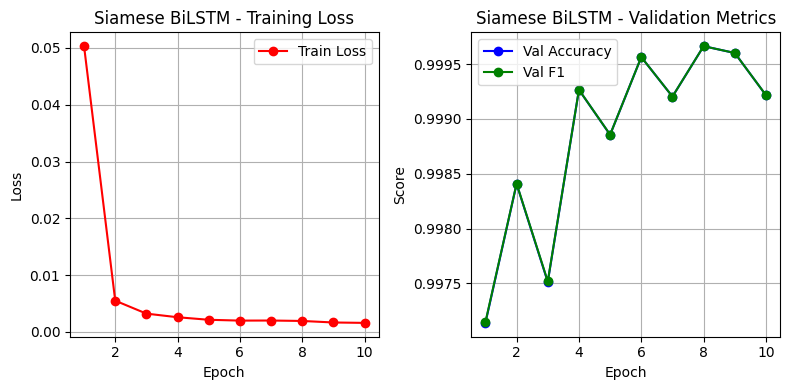

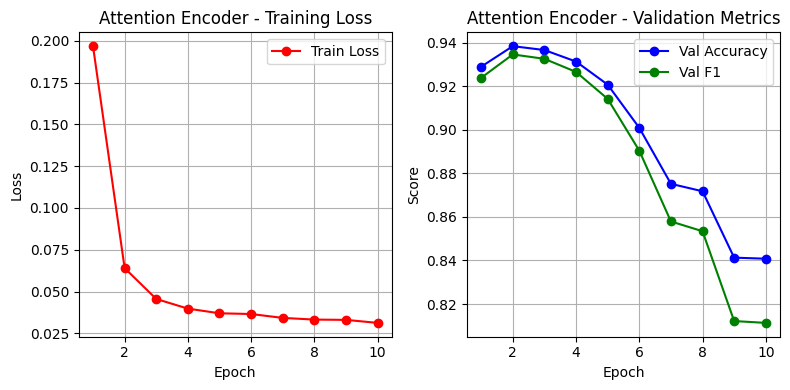

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'r-o', label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Training Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], 'b-o', label="Val Accuracy")
    plt.plot(epochs, history["val_f1"], 'g-o', label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"{title} - Validation Metrics")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(hist_siamese, "Siamese BiLSTM")
plot_history(hist_attn, "Attention Encoder")


Final Evaluation on Test Set

In [16]:

# ------------------------------
# Load best checkpoints and evaluate on test set
# ------------------------------
def load_best_and_eval(checkpoint_path, model_class, model_kwargs, test_loader, device):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model = model_class(**model_kwargs)
    model.load_state_dict(checkpoint['model_state'])
    model.to(device)
    metrics = eval_model(model, test_loader, device)
    return metrics, model

print("\n=== Final evaluation on test set ===")
siam_metrics, siam_model = load_best_and_eval("siamese_bilstm_best.pt", SiameseBiLSTM, {"vocab_size":vocab_size, "embed_dim":EMBED_DIM, "hidden_dim":HIDDEN_DIM}, test_loader, DEVICE)
attn_metrics, attn_model = load_best_and_eval("attn_encoder_best.pt", SelfAttentionEncoder, {"vocab_size":vocab_size, "embed_dim":EMBED_DIM, "n_heads":4, "ff_hidden":HIDDEN_DIM*2, "n_layers":1, "dropout":0.2, "max_len":MAX_SEQ_LEN}, test_loader, DEVICE)

print("\nSiamese Test Metrics:", {k: siam_metrics[k] for k in ['accuracy','precision','recall','f1','roc_auc','pr_auc']})
print("Attention Test Metrics:", {k: attn_metrics[k] for k in ['accuracy','precision','recall','f1','roc_auc','pr_auc']})



=== Final evaluation on test set ===

Siamese Test Metrics: {'accuracy': 0.9995454161028416, 'precision': 0.9990916580409388, 'recall': 1.0, 'f1': 0.9995456226554658, 'roc_auc': np.float64(0.9999783556490772), 'pr_auc': np.float64(0.9999569976067038)}
Attention Test Metrics: {'accuracy': 0.9360305311231394, 'precision': 0.9956735969234467, 'recall': 0.8758668809201624, 'f1': 0.9319355237848843, 'roc_auc': np.float64(0.9958552830457473), 'pr_auc': np.float64(0.9955450610670148)}


Qualitative Results: Correct vs Incorrect Predictions

In [18]:
# ------------------------------
# Qualitative examples: show some correct & incorrect matches
# ------------------------------
def get_examples(dataset_pairs, metrics_results):
    """Return list of (s1, s2, true_label, pred_label, correct_flag) tuples."""
    ys = metrics_results['y']
    preds = metrics_results['preds']
    examples = []
    for pair, y, p in zip(dataset_pairs, ys, preds):
        s1, s2, label = pair
        correct = (label == p)
        examples.append((s1, s2, label, p, correct))
    return examples


# collect test pairs list for qualitative display
test_pairs_list = test_pairs  # from earlier split

# Helper to print examples neatly
def print_examples(model_name, examples):
    corrects = [e for e in examples if e[4]]
    incorrects = [e for e in examples if not e[4]]

    print(f"\n=== {model_name} - Correct examples (up to 5) ===")
    for s1, s2, label, p, ok in corrects[:5]:
        print(f"LABEL: {label} | PRED: {p}")
        print("A:", s1[:200])
        print("B:", s2[:200])
        print("-" * 100)

    print(f"\n=== {model_name} - Incorrect examples (up to 5) ===")
    for s1, s2, label, p, ok in incorrects[:5]:
        print(f"LABEL: {label} | PRED: {p}")
        print("A:", s1[:200])
        print("B:", s2[:200])
        print("-" * 100)


# ------------------------------
# Get and show examples for both models
# ------------------------------
siam_examples = get_examples(test_pairs_list, siam_metrics)
attn_examples = get_examples(test_pairs_list, attn_metrics)

print_examples("Siamese BiLSTM", siam_examples)
print_examples("Attention Encoder", attn_examples)



=== Siamese BiLSTM - Correct examples (up to 5) ===
LABEL: 0 | PRED: 0
A: Term of Employment. The term of the Employee's employment under this Agreement (the "Term") shall commence on the Effective Date hereof and shall end on October 31, 2006, unless sooner terminated purs
B: Notices. Notice, requests, demands and other communications relating to this Subscription Agreement and the transactions contemplated herein shall be in writing and shall be deemed to have been duly g
----------------------------------------------------------------------------------------------------
LABEL: 1 | PRED: 1
A: Warranties. SELLER will pass through any applicable manufacturer's warranty to the benefit of BUYER. If any such manufacturer's warranty is not assignable, SELLER shall assist BUYER in pursuing any wa
B: Warranties. Contractor warrants that:
----------------------------------------------------------------------------------------------------
LABEL: 1 | PRED: 1
A: WHEREAS the Licensor is the owne

Saving Vocabulary for Reuse

In [19]:

# ------------------------------
# Save vocab for re-use
# ------------------------------
import json
vocab_path = "vocab.json"
with open(vocab_path, "w", encoding="utf8") as f:
    json.dump({"idx2token": vocab.idx2token}, f, ensure_ascii=False, indent=2)
print("Saved vocab to", vocab_path)

# ------------------------------
# End of notebook cell
# ------------------------------


Saved vocab to vocab.json
